In [2]:
from simulated_bifurcation import Ising
from tqdm import tqdm
import matplotlib.pyplot as plt
import pulp as pl
import mosek
import numpy as np
import time
import os

N_range = [10,30,40,50,100,200,300,500,700,1000]
scale_range = [4]
N_samples = 1

def generate_J_h(N_range,scale_range,N_samples):
    for N in N_range:
        for scale in scale_range:
            for i in range(N_samples):
                J = np.random.uniform(-10,10,size=(N, N))/(10**scale)
                J = (J + J.T)/2
                J = J - np.diag(np.diag(J))
                h = np.random.uniform(-10,10,size=N)/(10**(scale-int(i%5)+2))

                with open('test_MOSEK.nosync/test_MOSEK_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'wb') as f:
                    np.save(f, J)

                with open('test_MOSEK.nosync/test_MOSEK_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'wb') as f:
                    np.save(f, h)

                with open('test_MOSEK.nosync/test_SB_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'wb') as f:
                    np.save(f, J/4)

                with open('test_MOSEK.nosync/test_SB_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'wb') as f:
                    np.save(f, h/2 - sum([J[:,i]/8 for i in range(N)]) - sum([J[i,:]/8 for i in range(N)]))

generate_J_h(N_range,scale_range,N_samples)

In [3]:
def create_optimize_MOSEK(J,h,J_SB,h_SB,max_seconds=-1):
    time_1 = time.time()
    size = J.shape[0]

    model = pl.LpProblem("Linear Optimization", pl.LpMinimize)
    x = pl.LpVariable.dicts('x', list(range(size)), lowBound=0, upBound=1, cat='Integer')
    z = pl.LpVariable.dicts('z', [(i,j) for i in range(size) for j in range(size)], lowBound=0, upBound=1, cat='Integer')

    for i in range(size):
        for j in range(size):
            model += z[i,j] <= x[i]
            model += z[i,j] <= x[j]
            model += z[i,j] >= x[i] + x[j] -1

    model += pl.lpSum([(-1/2)*J[i][j]*z[i,j] for i in range(size) for j in range(size)]) + pl.lpSum([x[i]*h[i] for i in range(size)])

    if max_seconds == -1:
        model.solve(pl.MOSEK(msg=0, options={mosek.dparam.optimizer_max_time:60*5}))
        #model.solve(pl.PULP_MOSEK_CMD(msg=0, timeLimit=60*5))
    else:
        model.solve(pl.MOSEK(msg=0, options={mosek.dparam.optimizer_max_time:max_seconds}))

    spins = [1 if x[i].varValue >= 0.99 else -1 for i in range(size)]
    energy = (-1/2)*sum([sum([J_SB[i,j]*spins[j] for j in range(size)])*spins[i] for i in range(size)]) + sum([h_SB[i]*spins[i] for i in range(size)])[0]

    processing_time = time.time() - time_1
    return (processing_time,np.array(spins),energy)

In [4]:
def create_optimize_SB(J,h):
    time_1 = time.time()

    model = Ising(J,h)
    model.optimize(convergence_threshold = 50,
        sampling_period = 50,
        time_step = 0.01, 
        symplectic_parameter = 2,
        agents = 20,
        ballistic=True,
        heated=True,
        final_pressure=1.,
        pressure_slope=0.01,
        verbose=False)

    processing_time = time.time() - time_1
    return(processing_time, model.ground_state, model.energy)

In [6]:
import numpy as np
from simulated_bifurcation import Ising
import time

scale = 4
N = 1000

J = np.random.uniform(-10,10,size=(N, N))/(10**scale)
J = (J + J.T)/2
J = (J - np.diag(np.diag(J)))/4
h = np.random.uniform(-10,10,size=N)/(10**(scale-int(0%5)+2))
h = h/2 - sum([J[:,i]/8 for i in range(N)]) - sum([J[i,:]/8 for i in range(N)])

time_1 = time.time()

model = Ising(J,np.expand_dims(h,axis=1))
model.optimize(convergence_threshold = 50,
    sampling_period = 50,
    time_step = 0.01, 
    symplectic_parameter = 2,
    agents = 1,
    ballistic=True,
    heated=True,
    final_pressure=1.,
    pressure_slope=0.01,
    verbose=False)

processing_time = time.time() - time_1
print(processing_time)

4.100961685180664


In [5]:
def test_protocol(N_range,scale_range,N_samples,compute_SB=True):
    for N in tqdm(N_range):
        for scale in scale_range:
            for i in range(N_samples):
                with open('test_MOSEK.nosync/test_SB_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'rb') as f:
                    test_SB_J = np.load(f)

                with open('test_MOSEK.nosync/test_SB_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'rb') as f:
                    test_SB_h = np.expand_dims(np.load(f),axis=1)

                with open('test_MOSEK.nosync/test_MOSEK_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'rb') as f:
                    test_MOSEK_J = np.load(f)

                with open('test_MOSEK.nosync/test_MOSEK_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy', 'rb') as f:
                    test_MOSEK_h = np.load(f)

                processing_time_MOSEK, spins_MOSEK, energy_MOSEK = create_optimize_MOSEK(test_MOSEK_J,test_MOSEK_h,test_SB_J,test_SB_h)
                with open('test_MOSEK.nosync/results_MOSEK_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'wb') as f:
                    np.savez(f, processing_time=processing_time_MOSEK, spins=spins_MOSEK, energy=energy_MOSEK, J=test_SB_J, h=test_SB_h)

                if compute_SB:
                    processing_time_sb, spins_sb, energy_sb = create_optimize_SB(test_SB_J,test_SB_h)
                    processing_time_MOSEK_stopped, spins_MOSEK_stopped, energy_MOSEK_stopped = create_optimize_MOSEK(test_MOSEK_J,test_MOSEK_h,test_SB_J,test_SB_h,processing_time_sb)

                    with open('test_MOSEK.nosync/results_SB_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'wb') as f:
                        np.savez(f, processing_time=processing_time_sb, spins=spins_sb, energy=energy_sb, J=test_SB_J, h=test_SB_h)

                    with open('test_MOSEK.nosync/results_MOSEKs_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'wb') as f:
                        np.savez(f, processing_time=processing_time_MOSEK_stopped, spins=spins_MOSEK_stopped, energy=energy_MOSEK_stopped, J=test_SB_J, h=test_SB_h)
                
                    os.remove('test_MOSEK.nosync/test_SB_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy')
                    os.remove('test_MOSEK.nosync/test_SB_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy')
                    os.remove('test_MOSEK.nosync/test_MOSEK_J_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy')
                    os.remove('test_MOSEK.nosync/test_MOSEK_h_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npy')

In [6]:
test_protocol(N_range,scale_range,N_samples,compute_SB=True)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/lorpugliese/miniforge3/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
100%|██████████| 10/10 [1:02:01<00:00, 372.12s/it]


In [7]:
results = {}

for N in N_range:
    results[N] = {}
    for scale in scale_range:
        results[N][scale] = {}
        for i in range(N_samples):
            results[N][scale][i] = {}

            with open('test_MOSEK.nosync/results_MOSEK_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'rb') as f:
                data_MOSEK = np.load(f)
                results[N][scale][i]['MOSEK Energy'] = data_MOSEK['energy']
                results[N][scale][i]['MOSEK Spins'] = data_MOSEK['spins']
                results[N][scale][i]['MOSEK Time'] = data_MOSEK['processing_time']                

            with open('test_MOSEK.nosync/results_SB_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'rb') as f:
                data_SB = np.load(f)
                results[N][scale][i]['SB Energy'] = data_SB['energy']
                results[N][scale][i]['SB Spins'] = data_SB['spins']
                results[N][scale][i]['SB Time'] = data_SB['processing_time'] 

            with open('test_MOSEK.nosync/results_MOSEKs_' + str(N) + '_' + str(scale) + "_" + str(i) + '.npz', 'rb') as f:
                data_MOSEK_stopped = np.load(f)
                results[N][scale][i]['MOSEK Stopped Energy'] = data_MOSEK_stopped['energy']
                results[N][scale][i]['MOSEK Stopped Spins'] = data_MOSEK_stopped['spins']
                results[N][scale][i]['MOSEK Stopped Time'] = data_MOSEK_stopped['processing_time'] 

In [8]:
data_plots = {}
for N in N_range:
    data_plots[N] = {}
    for scale in scale_range:
        data_plots[N][scale] = {}
        data_plots[N][scale]["SB"] = sum([results[N][scale][i]['SB Energy'] for i in range(N_samples)])/N_samples
        data_plots[N][scale]["MOSEK Stopped"] = sum([results[N][scale][i]['MOSEK Stopped Energy'] for i in range(N_samples)])/N_samples
        data_plots[N][scale]["MOSEK"] = sum([results[N][scale][i]['MOSEK Energy'] for i in range(N_samples)])/N_samples
        
        data_plots[N][scale]["SB Time"] = sum([results[N][scale][i]['SB Time'] for i in range(N_samples)])/N_samples
        data_plots[N][scale]["MOSEK Stopped Time"] = sum([results[N][scale][i]['MOSEK Stopped Time'] for i in range(N_samples)])/N_samples
        data_plots[N][scale]["MOSEK Time"] = sum([results[N][scale][i]['MOSEK Time'] for i in range(N_samples)])/N_samples

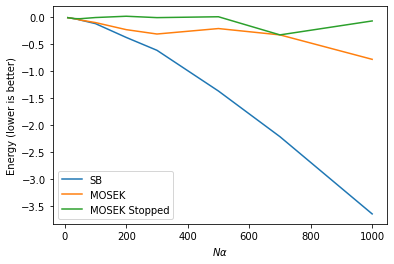

In [9]:
scale = 4
plt.plot(N_range,[data_plots[N][scale]["SB"] for N in N_range], label="SB")
plt.plot(N_range,[data_plots[N][scale]["MOSEK"] for N in N_range], label="MOSEK")
plt.plot(N_range,[data_plots[N][scale]["MOSEK Stopped"] for N in N_range], label="MOSEK Stopped")
plt.xlabel(r'$N \alpha$')
plt.ylabel('Energy (lower is better)')
plt.legend()

In [54]:
results[50][4][0]["MOSEK Energy"]

array(-0.04025549)

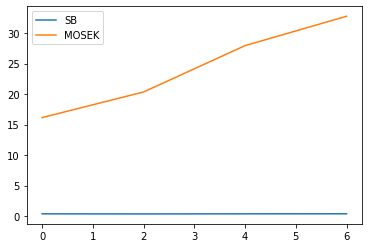

In [82]:
N = 40
plt.plot(scale_range,[sum([results[N][scale][i]['SB Time'] for i in range(N_samples)])/N_samples for scale in scale_range], label="SB")
plt.plot(scale_range,[sum([results[N][scale][i]['MOSEK Time'] for i in range(N_samples)])/N_samples for scale in scale_range], label="MOSEK")
plt.legend()

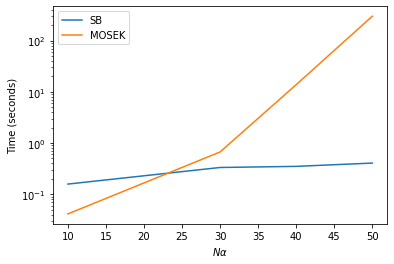

In [11]:
plt.plot(N_range[:4],[sum([data_plots[N][scale]["SB Time"] for scale in scale_range])/len(scale_range) for N in N_range[:4]], label="SB")
plt.plot(N_range[:4],[sum([data_plots[N][scale]["MOSEK Time"] for scale in scale_range])/len(scale_range) for N in N_range[:4]], label="MOSEK")
plt.xlabel(r'$N\alpha$')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend()